In [37]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import sklearn as sk
from PIL import Image, ImageOps, ImageDraw
from tensorflow.keras.models import Model

In [2]:
# Load the binary file
data_train = np.load('games_train.npz', allow_pickle=True)
X_train = data_train['images']
X_train.astype('float32')
y_train = data_train['labels']
label_names = data_train['label_names']



print(label_names)

['CSGO' 'Fortnite' 'Forza Horizon' 'Genshin impact' 'Minecraft' 'Terraria'
 'Valorant']


In [3]:
data_test = np.load('games_test.npz', allow_pickle=True)
X_test = data_test['images']
X_test.astype('float32')
y_test = data_test['labels']
label_names = data_test['label_names']

print(label_names)

['CSGO' 'Fortnite' 'Forza Horizon' 'Genshin impact' 'Minecraft' 'Terraria'
 'Valorant']


In [4]:
def crop(X):
    X[:, :10, :, :] = 0  # First 5 rows
    X[:, -10:, :, :] = 0  # Last 5 rows

    X[:, :, :10, :] = 0  # First 5 columns
    X[:, :, -10:, :] = 0  # Last 5 columns

In [5]:
crop(X_test)
crop(X_train)

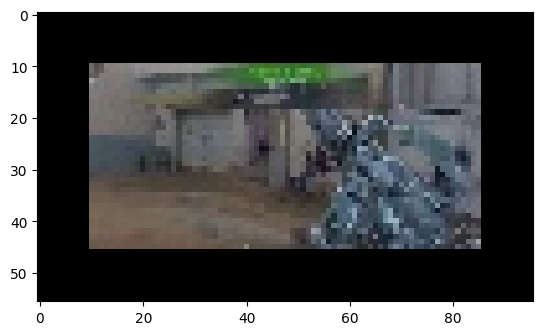

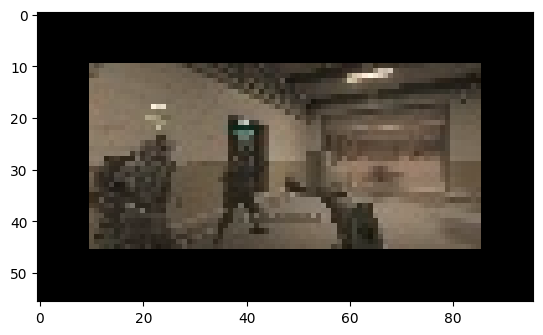

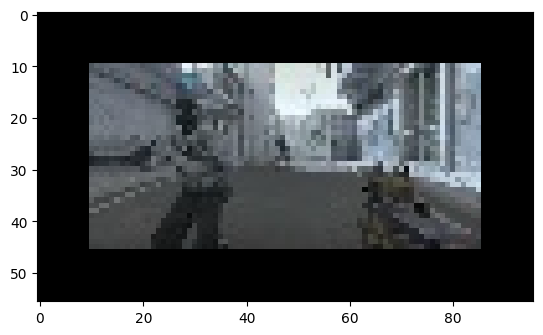

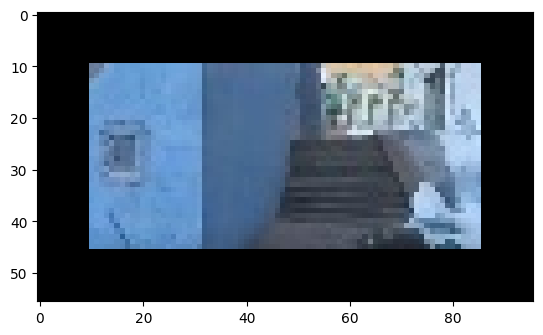

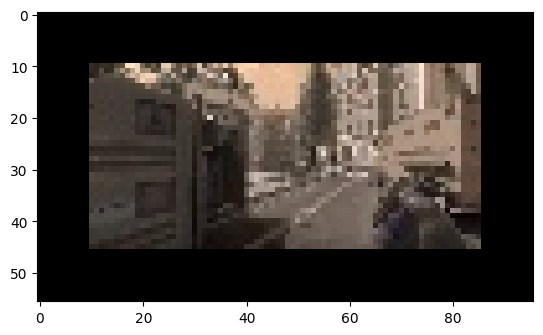

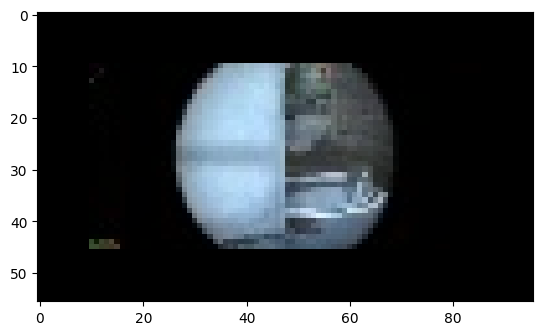

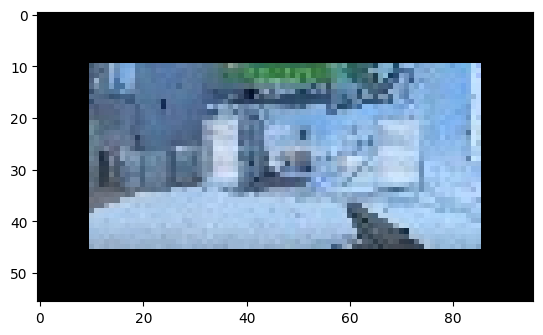

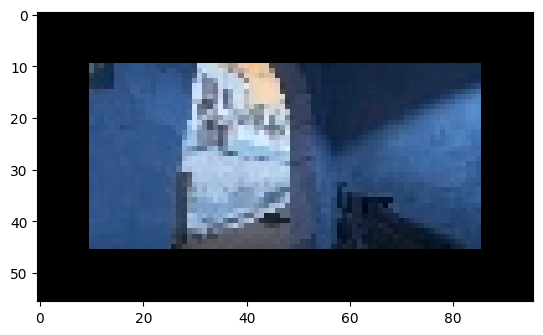

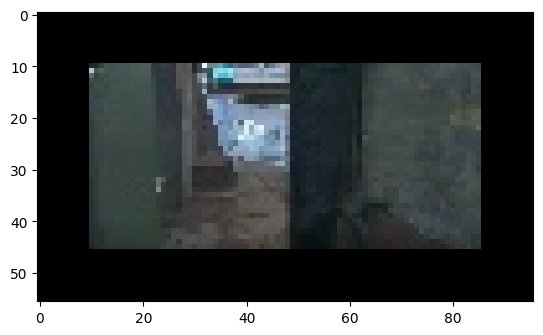

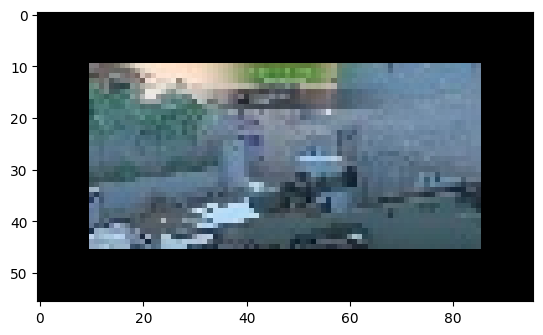

In [6]:
for i in range(10):
    plt.imshow(X_train[i])
    plt.show()

In [7]:
y_test = tf.keras.utils.to_categorical(y_test)
y_train = tf.keras.utils.to_categorical(y_train)

In [8]:
def nn_model(input_shape: tuple, num_classes: int):
    model = tf.keras.Sequential([
        Dense(32, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [9]:
def Cnn_model(input_shape: tuple, num_classes: int):
    model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: size of each processed batch
    :param int epochs: number of epochs
    """
    callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
    model.fit(x, y, epochs=10, batch_size=64, callbacks=[callback], validation_data=(x_test, y_test))

In [11]:
model_0 = nn_model(X_train.shape[1:], 7)

2024-05-26 00:26:03.746543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 00:26:03.746808: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
history = model_0.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4105 - loss: 1.5520 - val_accuracy: 0.4784 - val_loss: 1.4292
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.6724 - loss: 0.9732 - val_accuracy: 0.5730 - val_loss: 1.3024
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.7594 - loss: 0.7313 - val_accuracy: 0.7149 - val_loss: 0.8938
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8115 - loss: 0.5829 - val_accuracy: 0.6781 - val_loss: 0.9714
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.8392 - loss: 0.5000 - val_accuracy: 0.7313 - val_loss: 0.8135
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8599 - loss: 0.4395 - val_accuracy: 0.7677 - val_loss: 0.7219
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8771 - loss: 0.3816 - val_accuracy: 0.7569 - val_loss: 0.7662
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8847 - loss: 0.3562 - 

In [13]:
model = Cnn_model(X_train.shape[1:], 7)

/home/lehuang/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.7367 - loss: 0.8243 - val_accuracy: 0.8437 - val_loss: 0.4914
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9308 - loss: 0.2136 - val_accuracy: 0.8353 - val_loss: 0.5956
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9530 - loss: 0.1390 - val_accuracy: 0.8646 - val_loss: 0.5001
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.9683 - loss: 0.0955 - val_accuracy: 0.8576 - val_loss: 0.5251
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.9755 - loss: 0.0756 - val_accuracy: 0.8767 - val_loss: 0.4775
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9809 - loss: 0.0569 - val_accuracy: 0.8700 - val_loss: 0.4992
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9864 - loss: 0.0414 - val_accuracy: 0.8921 - val_loss: 0.4350
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.9879 - loss: 0.0340 - 

In [28]:
model.layers[0].output

<KerasTensor shape=(None, 54, 94, 32), dtype=float32, sparse=False, name=keras_tensor_7>

In [32]:
model.layers[0].input

<KerasTensor shape=(None, 56, 96, 3), dtype=float32, sparse=None, name=keras_tensor_6>

In [21]:
def visualize(model):
    #This is used to visulize what feautures CNN detects in each layer
    filters, biases = model.layers[0].get_weights()

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters, index = 6, 1
    plt.figure(figsize=(15, 15))
    for i in range(n_filters):
        f = filters[:, :, :, i]
        for j in range(f.shape[-1]):
            ax = plt.subplot(n_filters, f.shape[-1], index)
            plt.imshow(f[:, :, j], cmap='viridis')
            plt.axis('off')
            ax.set_title(f'Filter {i+1}, Channel {j+1}')
            index += 1
    plt.suptitle('First 6 Filters of the First Conv2D Layer', fontsize=20)
plt.show()

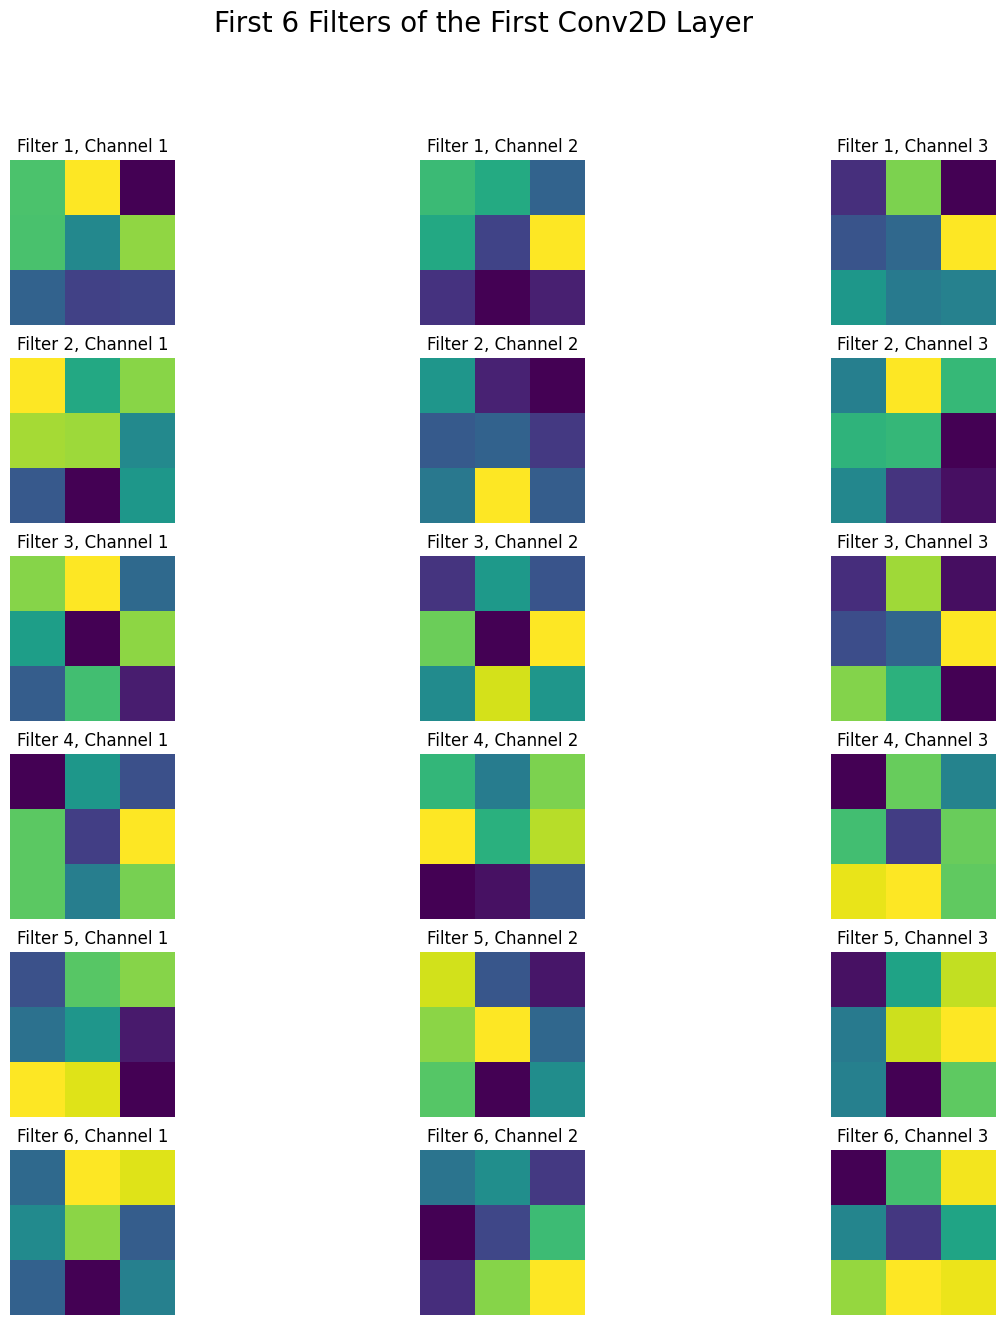

In [22]:
visualize(model)

In [17]:
filters, biases = model.layers[0].get_weights()
biases

array([ 0.09204198,  0.06073527,  0.03876182,  0.04130811,  0.00967505,
        0.03640728,  0.04548608, -0.00254265, -0.16979255,  0.02042431,
       -0.0285936 ,  0.0468301 ,  0.00327616, -0.00386669,  0.00829665,
        0.04863484,  0.01620314,  0.04810304,  0.04516696,  0.02116962,
        0.00715758,  0.06354562,  0.04168839,  0.03036539,  0.0671882 ,
       -0.03456818, -0.03477617, -0.08219961, -0.01223298,  0.05857043,
        0.00069084,  0.0222373 ], dtype=float32)

In [38]:
intermediate_layer_model = Model(inputs=model.layers[0].input, outputs=model.get_layer('dense_3').output)

intermediate_output = intermediate_layer_model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [39]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(intermediate_output)

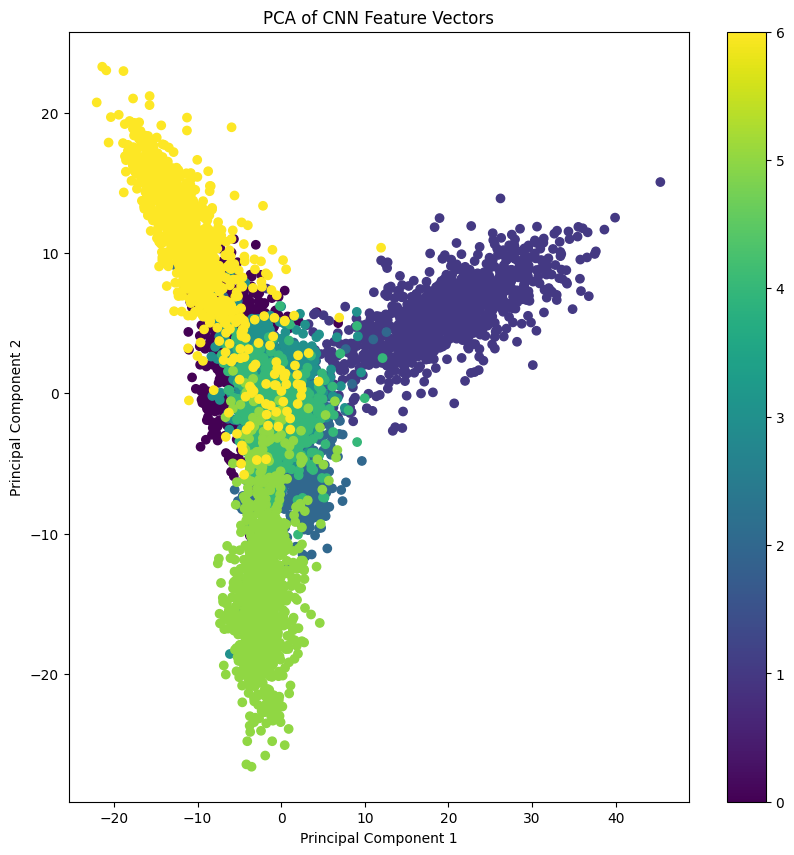

In [40]:
true_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=true_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('PCA of CNN Feature Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [26]:
def activatemap(model):
    layer_outputs = [layer.output for layer in model.layers[:8]] 
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(X_test[0].reshape(1, 28, 28, 1))

    first_layer_activation = activations[0]
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    for i in range(6):
        ax = axes[i]
        ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.show()

In [27]:
activatemap(model)

ValueError: The layer sequential_1 has never been called and thus has no defined input.

In [17]:
def predict(model, x: np.array, labels: list, file_name: str = None) -> np.array:
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    :return: the class prediction
    """
    lab = ['CSGO', 'Fortnite', 'Forza Horizon', 'Genshin impact', 'Minecraft', 'Terraria',
 'Valorant']


    y = model.predict(x)
    f, axes = plt.subplots(x.shape[0], 2, figsize=(33, 24))
    for i in range(x.shape[0]):
        axes[i, 0].imshow(x[i])
        axes[i, 1].barh(lab, y[i])
        
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()
    return y

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


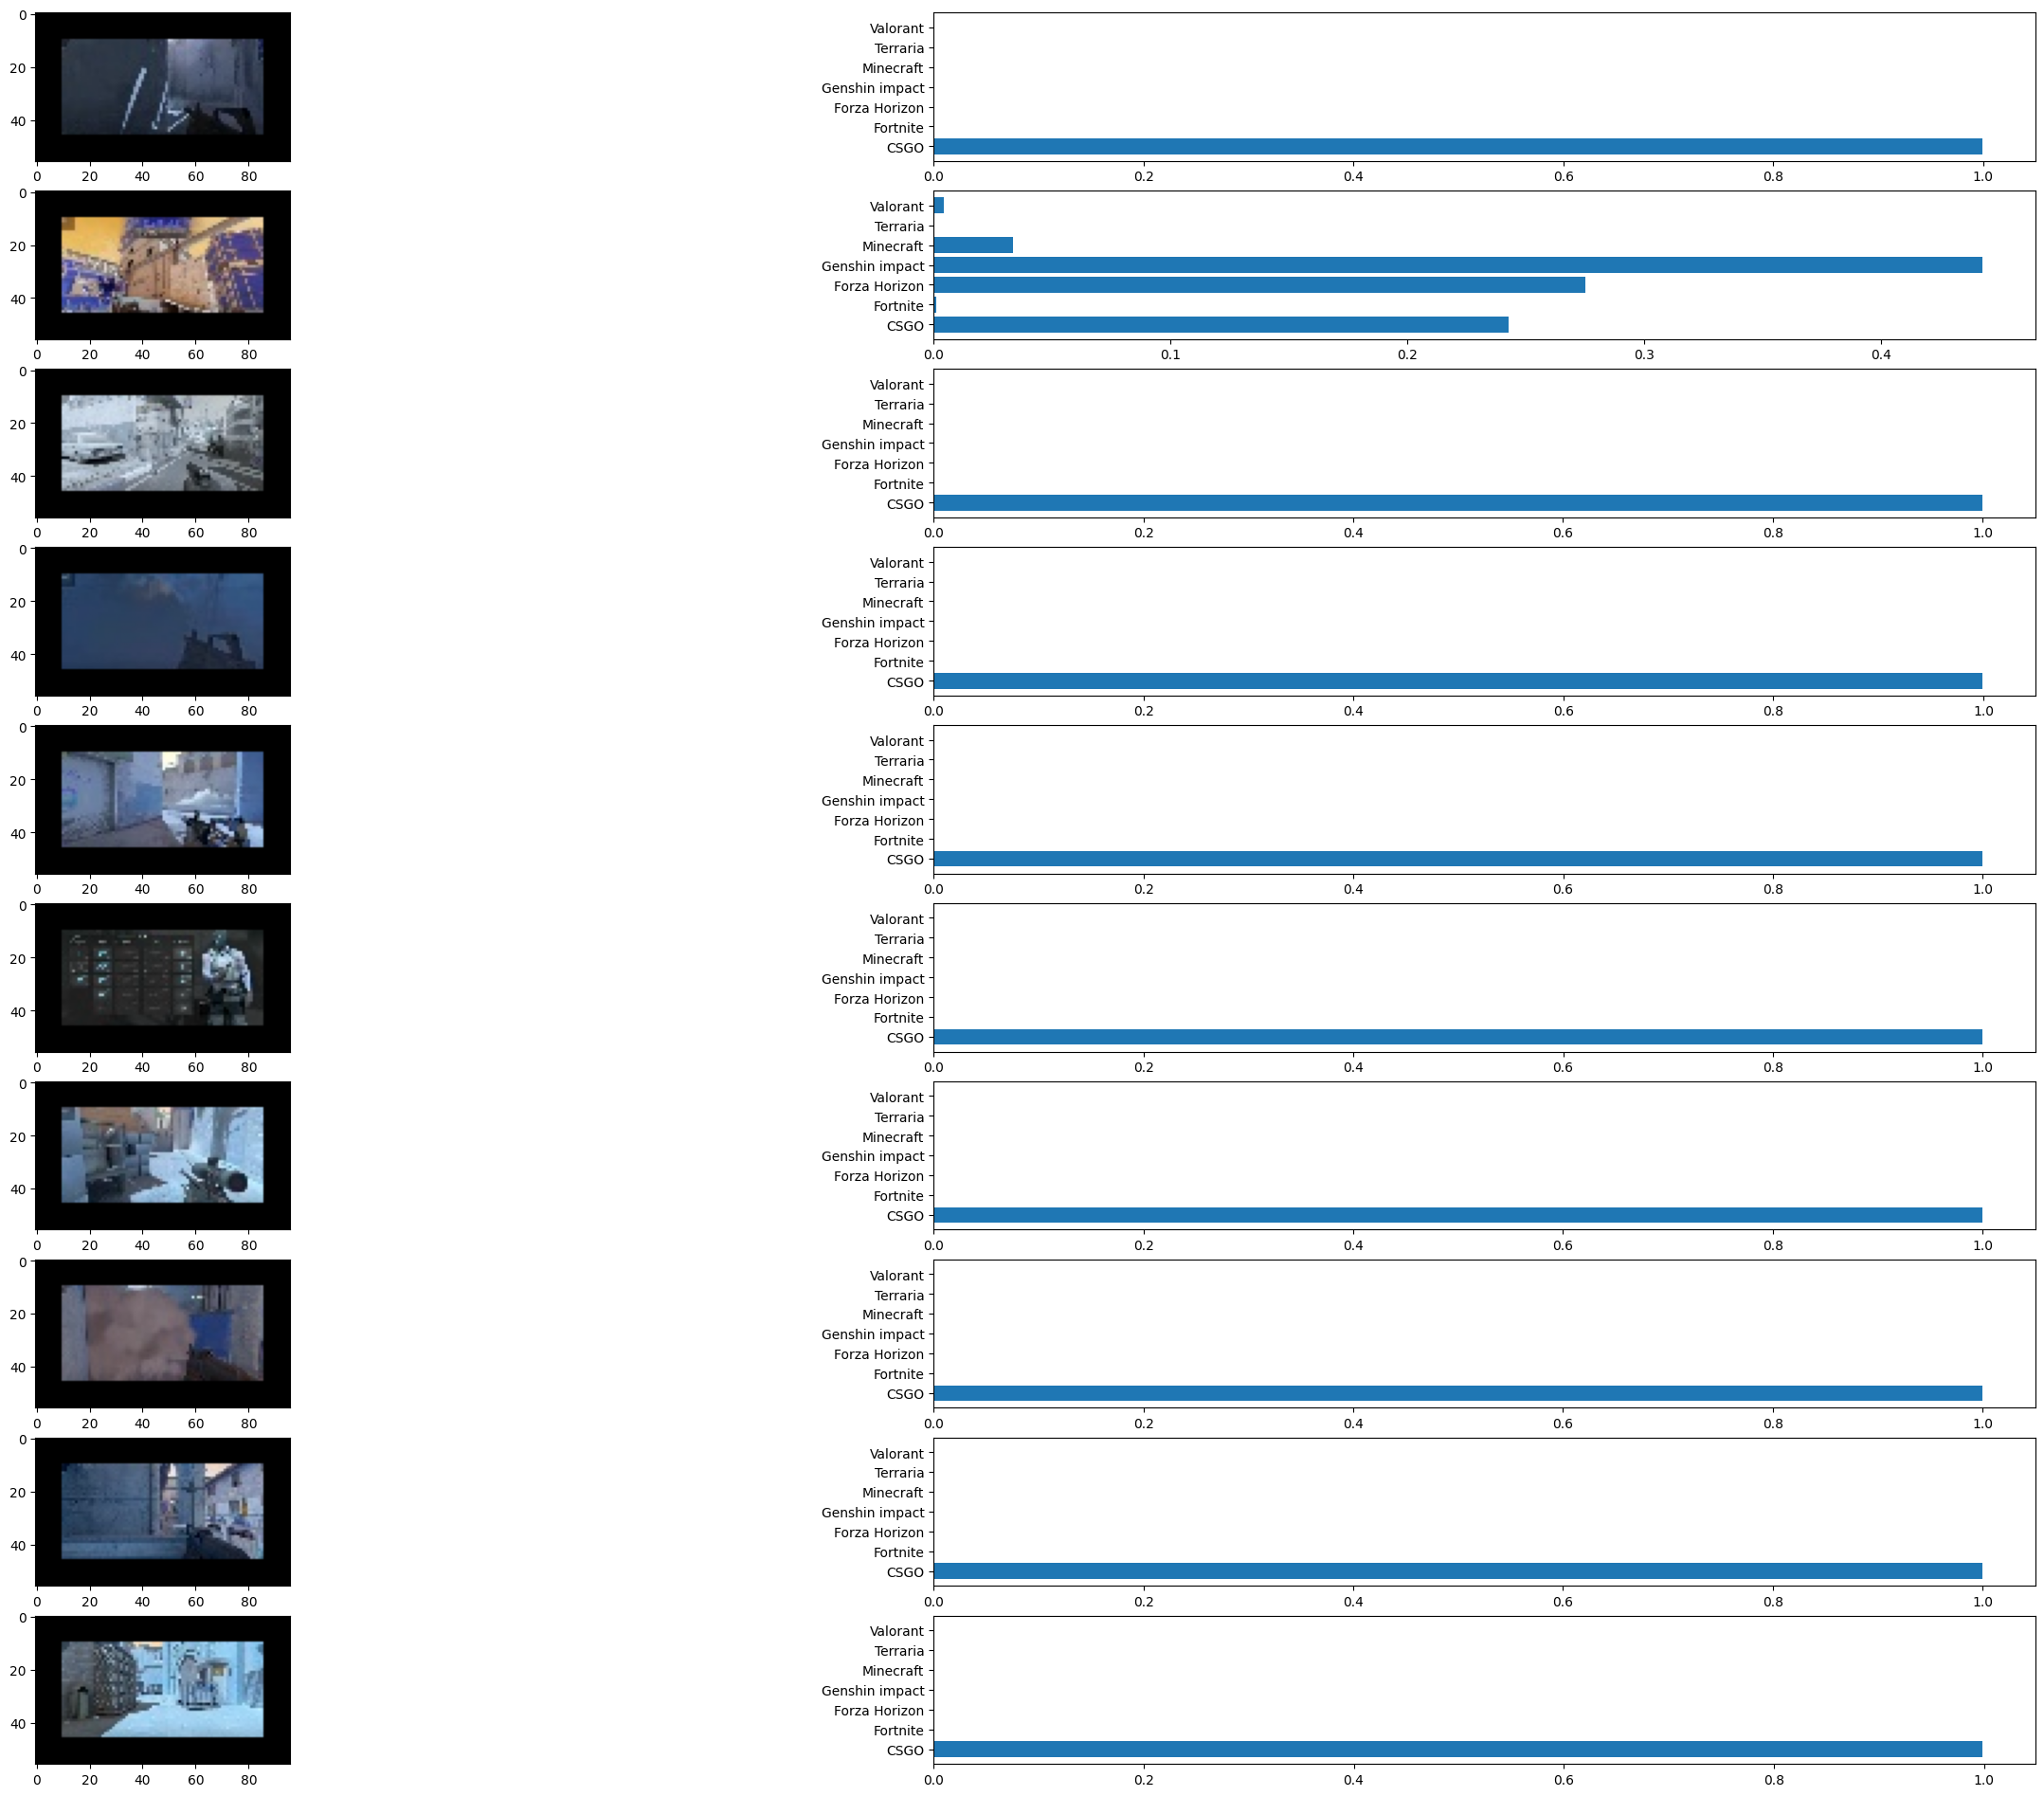

array([[9.99731004e-01, 2.28616555e-05, 2.26760327e-04, 1.75532932e-05,
        1.18475657e-06, 4.97360645e-07, 1.48260540e-07],
       [2.42864370e-01, 9.65168700e-04, 2.75181264e-01, 4.43015009e-01,
        3.33473496e-02, 1.96089110e-04, 4.43068473e-03],
       [9.99999642e-01, 6.51788679e-10, 2.22229829e-07, 9.40803968e-09,
        4.07670697e-09, 2.62440712e-11, 1.58591973e-07],
       [9.99404788e-01, 3.03249550e-08, 2.73366422e-05, 2.93224957e-06,
        4.54925830e-05, 3.65218540e-08, 5.19420195e-04],
       [9.99941230e-01, 6.15789419e-10, 6.96916629e-07, 1.32585170e-08,
        1.29610696e-08, 1.67619502e-10, 5.80687447e-05],
       [9.99964714e-01, 1.53469928e-11, 3.01470118e-05, 7.12630083e-07,
        2.95213862e-08, 8.36041569e-10, 4.42732062e-06],
       [9.99995470e-01, 4.69047201e-08, 7.35027129e-07, 4.42729302e-08,
        2.82803425e-09, 2.84674673e-10, 3.71796068e-06],
       [9.99998331e-01, 1.87895408e-10, 9.24578160e-07, 9.16876530e-09,
        1.03181046e-08, 2

In [18]:
predict(model, X_test[:10], y_test[:10])

In [19]:

def confusion_matrix(model, x_test: np.array, y_test: np.array, labels: list) -> pd.DataFrame:
    """
    Predict on x_test using model
    Use sklearn.metrics.confusion_matrix to get the matrix
    Prettify the result

    :param model: keras model
    :param numpy.array x: a few test points to predict
    :param numpy.array x: true values associated with x_test
    :param list labels: list of names of labels
    """
    lab = ['CSGO', 'Fortnite', 'Forza Horizon', 'Genshin impact', 'Minecraft', 'Terraria',
 'Valorant']

    
    pred = model.predict(x_test)
    df = pd.DataFrame(metrics.confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
    # making the table look fancy
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    df = df.rename({i: lab[i] for i in range(len(lab))}, axis='columns')
    df = df.rename({i: lab[i] for i in range(len(lab))})
    return df

In [21]:
conf_matrix = confusion_matrix(model_0, X_test, y_test, label_names)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [22]:
conf_matrix

,CSGO,Fortnite,Forza Horizon,Genshin impact,Minecraft,Terraria,Valorant
CSGO,786,2,33,24,17,16,122
Fortnite,14,820,22,62,13,0,69
Forza Horizon,27,6,816,25,24,49,53
Genshin impact,117,13,100,517,89,22,142
Minecraft,14,9,49,79,728,3,118
Terraria,2,31,12,25,81,843,6
Valorant,11,3,29,36,5,1,915


In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,377 (3.49 MB)

 Trainable params: 913,927 (3.49 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [27]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense_3').output)

intermediate_output = intermediate_layer_model.predict(X_test)

ValueError: The layer sequential_1 has never been called and thus has no defined input.